In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tensorflow.keras.models import Sequential, load_model
from tqdm import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from scipy.linalg import sqrtm
import pickle

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [2]:
IMG_HEIGHT = 176
IMG_WIDTH = 208

image_paths = glob("/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train/VeryMildDemented/*.jpg")
images = []

for img_path in tqdm(image_paths, desc="Loading Images"):
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

images = np.array(images)
print("Loaded shape:", images.shape)

train_set = (images.astype('float32') - 127.5) / 127.5

BUFFER_SIZE = len(train_set)
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Loading Images: 100%|██████████| 8960/8960 [01:00<00:00, 147.22it/s]


Loaded shape: (8960, 176, 208, 1)


In [3]:
def make_generator_model():
    model = Sequential(name="Generator")
    model.add(layers.Input(shape=(256,)))
    model.add(layers.Dense(22 * 26 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((22, 26, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():
    model = Sequential(name="Discriminator")
    model.add(layers.Input(shape=(176, 208, 1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()


In [4]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_labels = tf.ones_like(real_output) * 0.9
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5)

def calculate_fid(real_images, generated_images):
    real_images = tf.image.resize(real_images, (299, 299))
    generated_images = tf.image.resize(generated_images, (299, 299))
    real_images_rgb = tf.repeat(real_images, 3, axis=-1)
    generated_images_rgb = tf.repeat(generated_images, 3, axis=-1)
    real_images_rgb = tf.keras.applications.inception_v3.preprocess_input(real_images_rgb)
    generated_images_rgb = tf.keras.applications.inception_v3.preprocess_input(generated_images_rgb)
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    real_features = inception_model(real_images_rgb)
    generated_features = inception_model(generated_images_rgb)
    mean_real = np.mean(real_features, axis=0)
    mean_fake = np.mean(generated_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    cov_fake = np.cov(generated_features, rowvar=False)
    fid = np.linalg.norm(mean_real - mean_fake)**2 + np.trace(cov_real + cov_fake - 2 * sqrtm(np.dot(cov_real, cov_fake)))
    return fid

def calculate_inception_score(generated_images):
    generated_images = tf.image.resize(generated_images, (299, 299))
    generated_images_rgb = tf.repeat(generated_images, 3, axis=-1)
    generated_images_rgb = tf.keras.applications.inception_v3.preprocess_input(generated_images_rgb)
    inception_model = InceptionV3(include_top=True, weights='imagenet')
    preds = inception_model.predict(generated_images_rgb)
    split_scores = []
    for i in range(preds.shape[0]):
        p_y = preds[i]
        kl_div = p_y * (np.log(p_y) - np.log(np.mean(preds, axis=0)))
        split_scores.append(np.sum(kl_div))
    return np.exp(np.mean(split_scores))


In [5]:
EPOCHS = 100
NOISE_DIM = 256
SEED = tf.random.normal([16, NOISE_DIM])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    images_noisy = images + tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=0.05)
    images_noisy = tf.clip_by_value(images_noisy, -1.0, 1.0)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images_noisy, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input, output_dir="generated_images"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    predictions = model(test_input[:8], training=False)  # Generate 8 images
    fig = plt.figure(figsize=(8, 1))  # 8 in one row

    for i in range(8):
        plt.subplot(1, 8, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"epoch_{epoch:03d}.png"))
    plt.close()

def plot_losses(gen_losses, disc_losses, output_dir="logs"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator vs Discriminator Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "loss_plot.png"))
    plt.close()


In [ ]:
# Define seed for generating 8 images
NOISE_DIM = 256
SEED = tf.random.normal([8, NOISE_DIM])  # ⬅Generates 8 images per epoch

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 2))  # 8 images = 4 cols x 2 rows

    for i in range(predictions.shape[0]):
        plt.subplot(2, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"generated_images/image_at_epoch_{epoch:04d}.png")
    plt.close()  # Avoid showing inline in Kaggle

def plot_losses(gen_losses, disc_losses, save_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator vs Discriminator Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, "loss_plot.png"))
    plt.show()

def train(dataset, epochs, checkpoint_dir="checkpoints", logs_dir="logs"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)
    os.makedirs("generated_images", exist_ok=True)

    start_epoch = 1
    best_fid = float('inf')
    best_is = float('-inf')
    gen_losses, disc_losses = [], []

    # Resume from checkpoint if available
    log_path = os.path.join(logs_dir, "training_log.npz")
    if os.path.exists(log_path):
        data = np.load(log_path, allow_pickle=True)
        gen_losses = data["gen_losses"].tolist()
        disc_losses = data["disc_losses"].tolist()
        best_fid = data["best_fid"]
        best_is = data["best_is"]
        start_epoch = len(gen_losses) + 1
        generator.load_weights(os.path.join(checkpoint_dir, "generator_latest.weights.h5"))
        discriminator.load_weights(os.path.join(checkpoint_dir, "discriminator_latest.weights.h5"))
        print(f"Resumed training from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs + 1):
        gen_loss_avg = 0
        disc_loss_avg = 0
        num_batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_avg += gen_loss.numpy()
            disc_loss_avg += disc_loss.numpy()
            num_batches += 1

        gen_loss_avg /= num_batches
        disc_loss_avg /= num_batches
        gen_losses.append(gen_loss_avg)
        disc_losses.append(disc_loss_avg)

        print(f"Epoch {epoch} | Gen Loss: {gen_loss_avg:.4f} | Disc Loss: {disc_loss_avg:.4f}")

        # Generate and evaluate images
        generated_images = generator(SEED, training=False)
        fid = calculate_fid(image_batch, generated_images)
        is_score = calculate_inception_score(generated_images)
        print(f"Epoch {epoch} | FID: {fid:.4f} | IS: {is_score:.4f}")

        # Save generated sample
        generate_and_save_images(generator, epoch, SEED)

        # Save best generator model by FID
        if fid < best_fid:
            best_fid = fid
            generator.save(os.path.join(checkpoint_dir, f"generator_best_fid_epoch_{epoch}.h5"))

        # Save best generator model by IS
        if is_score > best_is:
            best_is = is_score
            generator.save(os.path.join(checkpoint_dir, f"generator_best_is_epoch_{epoch}.h5"))

        # Save latest weights every epoch
        generator.save_weights(os.path.join(checkpoint_dir, "generator_latest.weights.h5"))
        discriminator.save_weights(os.path.join(checkpoint_dir, "discriminator_latest.weights.h5"))

        # Save losses and metrics for resume
        np.savez(log_path,
                 gen_losses=gen_losses,
                 disc_losses=disc_losses,
                 best_fid=best_fid,
                 best_is=best_is)

    # Final plot
    plot_losses(gen_losses, disc_losses, logs_dir)


Epoch 1 | Gen Loss: 2.8701 | Disc Loss: 0.6940
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Epoch 1 | FID: 53.8872-0.0000j | IS: 1.0079
Epoch 2 | Gen Loss: 2.0364 | Disc Loss: 0.9644
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 2 | FID: 71.1943-0.0000j | IS: 1.3743
Epoch 3 | Gen Loss: 1.8237 | Disc Loss: 1.0461
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 3 | FID: 52.2107-0.0000j | IS: 1.0281
Epoch 4 | Gen Loss: 1.3632 | Disc Loss: 1.1162
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 4 | FID: 49.9974-0.0000j | IS: 1.0308
Epoch 5 | Gen Loss: 1.0063 | Disc Loss: 1.2684
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 5 | FID: 54.0419-0.0000j | IS: 1.0046
Epoch 6 | Gen Loss: 1.2235 | Disc Loss: 1.1921
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 6 | FID: 59.3954-0.0000j | IS: 1.0088
Epoch 7 | Gen Loss: 0.9820 | Disc Loss: 1.1885
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 7 | FID: 41.0186-0.0000j | IS: 1.0114
Epoch 8 | Gen Loss: 1.0622 | Disc Loss: 1.1961
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Epoch 8 | FID: 68.4435-0.000

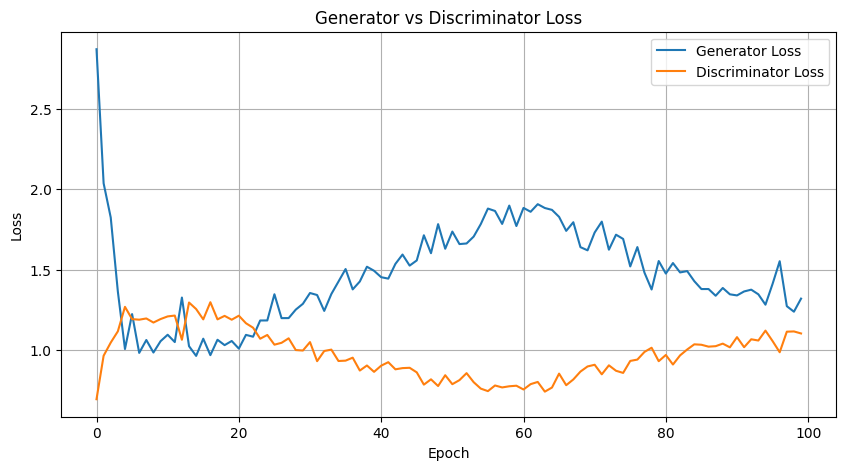

In [11]:
train(train_dataset, EPOCHS)


In [ ]:
import os

# Define the checkpoint directory
checkpoint_dir = "checkpoints"

# List all files in the checkpoint directory
saved_models = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".h5") or f.endswith(".weights.h5")])

# Print the results
print("Saved Models and Weights:")
for model_file in saved_models:
    print(f"- {model_file}")


📦 Saved Models and Weights:
- discriminator_latest.weights.h5
- generator_best_fid_epoch_1.h5
- generator_best_fid_epoch_13.h5
- generator_best_fid_epoch_14.h5
- generator_best_fid_epoch_15.h5
- generator_best_fid_epoch_16.h5
- generator_best_fid_epoch_3.h5
- generator_best_fid_epoch_34.h5
- generator_best_fid_epoch_4.h5
- generator_best_fid_epoch_43.h5
- generator_best_fid_epoch_69.h5
- generator_best_fid_epoch_7.h5
- generator_best_is_epoch_1.h5
- generator_best_is_epoch_2.h5
- generator_latest.weights.h5


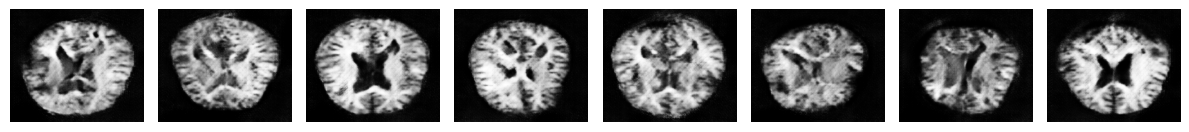

In [16]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load a specific saved model (change filename to your desired one)
generator = load_model("checkpoints/generator_best_fid_epoch_69.h5")

# Generate 8 new images
noise = tf.random.normal([8, 256])
generated_images = generator(noise, training=False)

# Display them
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis("off")
plt.tight_layout()
plt.show()


In [17]:
!zip -r checkpoints.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/generator_best_fid_epoch_43.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_13.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_15.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_69.h5 (deflated 7%)
  adding: checkpoints/discriminator_latest.weights.h5 (deflated 8%)
  adding: checkpoints/generator_best_is_epoch_2.h5 (deflated 8%)
  adding: checkpoints/generator_best_fid_epoch_3.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_34.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_16.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_14.h5 (deflated 7%)
  adding: checkpoints/generator_latest.weights.h5 (deflated 8%)
  adding: checkpoints/generator_best_fid_epoch_7.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_4.h5 (deflated 7%)
  adding: checkpoints/generator_best_fid_epoch_1.h5 (deflated 8%)
  adding: checkpoints/generator_bes

In [18]:
from IPython.display import FileLink

# Create a clickable download link
FileLink('checkpoints.zip')


/kaggle/working/checkpoints.zip

In [19]:
import shutil

# Zip the logs folder
shutil.make_archive("training_logs", 'zip', "logs")

# Download it
from IPython.display import FileLink
FileLink("training_logs.zip")


/kaggle/working/training_logs.zip

In [ ]:
# Zip the generated images folder
shutil.make_archive("generated_images", 'zip', "generated_images")

# Download it
FileLink("generated_images.zip")
